In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, v2
from torch.utils.data import DataLoader
from torchvision import models

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using: {device}")

Using: cuda


In [3]:
from pathlib import Path
train_dir = Path("train/")
val_dir = Path("val/")
test_dir = Path("test/")

## Augmentation

In [4]:
data_augmentation = transforms.Compose([
    # Convert the image to a PyTorch Tensor
    transforms.v2.ToImage(),
    # Use torch.uint8 dtype, especially for resizing
    transforms.v2.ToDtype(torch.uint8, scale=True),
    # Resize the image to 128x128 pixels
    transforms.v2.Resize((256, 256), antialias=True),
    # Crop a square in the center of the image
    transforms.v2.CenterCrop(224),

    transforms.v2.TrivialAugmentWide(31),

    transforms.v2.ToDtype(torch.float32, scale=True),
    # Normalize the image with mean and standard deviation
    transforms.v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.v2.ToImage(),
    transforms.v2.ToDtype(torch.uint8, scale=True),
    transforms.v2.Resize((256, 256), antialias=True),
    transforms.v2.CenterCrop(224),
    transforms.v2.ToDtype(torch.float32, scale=True),
    transforms.v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

In [5]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_augmentation)
val_data = datasets.ImageFolder(root=val_dir, transform=test_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}\nValidation data:\n{val_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 18722
    Root location: train
    StandardTransform
Transform: Compose(
               ToImage()
               ToDtype(scale=True)
               Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
               CenterCrop(size=(224, 224))
               TrivialAugmentWide(interpolation=InterpolationMode.NEAREST, num_magnitude_bins=31)
               ToDtype(scale=True)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 4171
    Root location: test
    StandardTransform
Transform: Compose(
               ToImage()
               ToDtype(scale=True)
               Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
               CenterCrop(size=(224, 224))
               ToDtype(scale=True)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 

In [6]:
class_names = train_data.classes
class_names

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [7]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=16, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True, # shuffle the data?
                              pin_memory=True) #Uses GPU memory to load data faster

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=16, 
                             shuffle=False, # shuffle the data?
                             pin_memory=True) #Uses GPU memory to load data faster

val_dataloader = DataLoader(dataset=val_data,
                            batch_size=BATCH_SIZE,
                            num_workers=16,
                            shuffle=True, # shuffle the data?
                            pin_memory=True) #Uses GPU memory to load data faster


train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1db5c022550>,
 <torch.utils.data.dataloader.DataLoader at 0x1db55245a90>)

## Setting up the pretrained model

Here we will be using the pretrained model from the EfficientNetV2 (m) architecture. This architecture is a state of the art architecture that is very efficient in terms of the number of parameters and the number of floating point operations required to make a prediction. This makes it very useful for mobile applications.

Paper: https://arxiv.org/pdf/2104.00298.pdf

In [8]:
weights = torchvision.models.EfficientNet_V2_M_Weights.DEFAULT # Default weights for EfficientNetV2-M (imagenet21k-ft1k)
model = torchvision.models.efficientnet_v2_m(weights= weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
# ### Only to check the model summary (uses GPU memory so bad if used before training)
# import torchinfo
# from torchinfo import summary
# summary(model, input_size=(BATCH_SIZE, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [9]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [10]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [11]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
# ### Only to check the model summary (uses GPU memory so bad if used before training)
# import torchinfo
# from torchinfo import summary
# summary(model, input_size=(BATCH_SIZE, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### Now Model Training

In [12]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for X, y in dataloader:
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad(set_to_none=True)

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [13]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for X, y in dataloader:
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [14]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(1,epochs+1):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        if epoch % 5 == 0 or epoch == epochs:
            test_loss, test_acc = test_step(model=model,
                dataloader=test_dataloader,
                loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
        )
        if epoch % 5 == 0 or epoch == epochs:
            print(
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f} | "
            )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [17]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model.parameters(), lr=0.004, weight_decay=0.0006)

model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 0.2595 | train_acc: 0.9324 | 
Epoch: 2 | train_loss: 0.2215 | train_acc: 0.9373 | 
Epoch: 3 | train_loss: 0.2175 | train_acc: 0.9390 | 
Epoch: 4 | train_loss: 0.2121 | train_acc: 0.9393 | 
Epoch: 5 | train_loss: 0.2098 | train_acc: 0.9426 | 
test_loss: 0.1149 | test_acc: 0.9692 | 
Epoch: 6 | train_loss: 0.2127 | train_acc: 0.9387 | 
Epoch: 7 | train_loss: 0.2014 | train_acc: 0.9431 | 
Epoch: 8 | train_loss: 0.1942 | train_acc: 0.9432 | 
Epoch: 9 | train_loss: 0.1995 | train_acc: 0.9413 | 
Epoch: 10 | train_loss: 0.2089 | train_acc: 0.9396 | 
test_loss: 0.1174 | test_acc: 0.9723 | 


In [15]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "AnimalClassifierEffNetV2-M.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# # Save model
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\AnimalClassifierEffNetV2-M.pth


In [17]:
### for evalutation
# # Load model

loaded_model = torchvision.models.efficientnet_v2_m().to(device)
loaded_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


all_preds = []
all_labels = []

with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        outputs = loaded_model(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.52      0.45      0.48       364
           1       0.33      0.49      0.39       296
           2       0.48      0.41      0.44       465
           3       0.23      0.22      0.23       274
           4       0.45      0.65      0.54       758
           5       0.46      0.27      0.34       268
           6       0.31      0.40      0.35       410
           7       0.34      0.28      0.31       334
           8       0.67      0.54      0.60       752
           9       0.51      0.23      0.32       250

    accuracy                           0.44      4171
   macro avg       0.43      0.39      0.40      4171
weighted avg       0.46      0.44      0.44      4171

[[162  19  28   7  33   5  16   5  76  13]
 [  9 144  11  12  67   8  17  17   8   3]
 [ 20  25 189  27  77   5  55  27  31   9]
 [  6  21  21  61  58  12  55  22  15   3]
 [ 15  69  23  19 496   6  80  28  14   8]
 [  6  14  12  37  53  72 

In [20]:
custom_image_path = Path("customImg/") / "cat.jpg"

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[143., 142., 141.,  ...,  24.,  24.,  24.],
         [143., 142., 140.,  ...,  22.,  22.,  22.],
         [142., 141., 139.,  ...,  20.,  20.,  20.],
         ...,
         [  9.,   9.,   9.,  ...,  40.,  40.,  40.],
         [  9.,   9.,   9.,  ...,  40.,  40.,  40.],
         [  9.,   9.,   9.,  ...,  40.,  40.,  40.]],

        [[123., 122., 121.,  ...,  18.,  18.,  18.],
         [123., 122., 120.,  ...,  16.,  16.,  16.],
         [122., 121., 119.,  ...,  14.,  14.,  14.],
         ...,
         [ 33.,  33.,  33.,  ...,  53.,  53.,  53.],
         [ 33.,  33.,  33.,  ...,  53.,  53.,  53.],
         [ 33.,  33.,  33.,  ...,  53.,  53.,  53.]],

        [[ 98.,  97.,  96.,  ...,  28.,  28.,  28.],
         [ 98.,  97.,  95.,  ...,  26.,  26.,  26.],
         [ 97.,  96.,  94.,  ...,  24.,  24.,  24.],
         ...,
         [ 33.,  33.,  33.,  ...,  62.,  62.,  62.],
         [ 33.,  33.,  33.,  ...,  62.,  62.,  62.],
         [ 33.,  33.,  33.,  ...

In [21]:
def plot_and_pred_img(model: torch.nn.Module,
                      image_path: str,
                      class_names: list,
                      transform: torch.nn.Module,
                      device: torch.device = device):
    """
    Model prediction, plots image and returns predicted class along with probability.
    """

    # 1. Load in custom image
    custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the target image by 255 (max pixel value)
    custom_image /= 255.0

    # 3. Transform custom image
    custom_image_transformed = transform(custom_image)

    # 4. Make a prediction on image with an extra dimension
    model.to(device)
    model.eval()
    with torch.inference_mode():
        # 5. Add an extra dimension to image
        custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)

        custom_image_pred = model(custom_image_transformed.to(device))
    
    # 6. Convert prediction probabilities -> prediction labels
    custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)

    print(custom_image_pred)
    
    # 7. Convert prediction probabilities -> prediction labels
    custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)

    # 8. Plot image and predicted class
    plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
    if class_names:
        title = f"Pred: {class_names[custom_image_pred_label.cpu()]} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {custom_image_pred_label} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);


tensor([[-1.1370,  5.1391, -1.3405, -2.2446,  0.9230,  0.1401, -0.7358, -0.3371,
         -0.5271,  0.2556]], device='cuda:0')


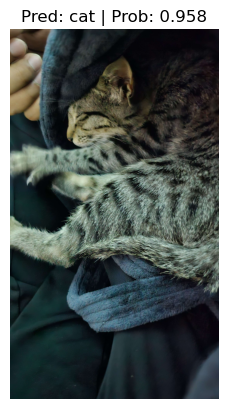

In [22]:
plot_and_pred_img(model=model,
                  image_path=custom_image_path,
                  class_names=class_names,
                  transform=test_transform)